In [3]:
"""notebook for release qc metrics."""

import sys

sys.path.append("../../gentropy/src/")
release_path="../../otg_releases"
release_ver="2403"


In [4]:
from gentropy.common.session import Session
from pyspark.sql import functions as f
import matplotlib.pyplot as plt

session=Session()

variant_index_path = f"{release_path}/{release_ver}/variant_index"
variant_index=session.spark.read.parquet(variant_index_path, recursiveFileLookup=True)

# How many variants?
print("Variant index contains ", variant_index.select(f.col("variantId")).distinct().count(), " unique variants.")

# How many variants with MAF>=0.01 for EUR population?
#variant_index.filter(variant_index["alleleFrequencies.populationName"] > 0.05).show(10, False)

# How many variants that are presented in GnomAD LD for EUR (if possible, not sure)?


Variant index contains  345286  unique variants.


In [5]:
#v2g_path='gs://genetics_etl_python_playground/releases/24.03/variant_to_gene'
v2g_path=f"{release_path}/{release_ver}/variant_to_gene"
v2g=session.spark.read.parquet(v2g_path, recursiveFileLookup=True)

#How many variants?
print("Unique variants in v2g release: ", v2g.select(f.col("variantId")).distinct().count(), ", total variant to gene assignments: ", v2g.count(), ", number of v2g assignments where score > 0.8: ", v2g.filter(v2g["score"] > 0.8).count())
#v2g.select().toPandas().plot.hist()
#v2g.show()

Unique variants in v2g release:  329279 , total variant to gene assignments:  8190773 , number of v2g assignments where score > 0.8:  1747693


<Axes: ylabel='Frequency'>

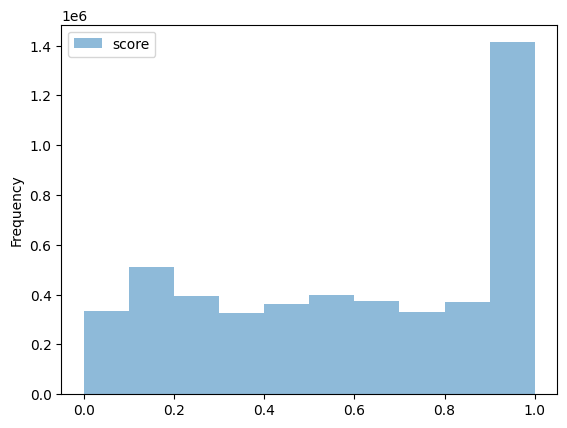

In [6]:
#The histogram/density plot for “score”

v2g.select(f.col("score")).toPandas().plot.hist(bins=10, alpha=0.5, label="v2g scores")

Number of unique finngen studies:  2408


Number of unique eQTLcat studies:  1801315


Number of unqiue eQTLcat tissues:  76
Number of unique gwascat studies:  79858
Number of unique SUMSTATS gwascat studies:  18435


<Axes: title={'center': 'Curated GWAScat sample size'}, ylabel='Frequency'>

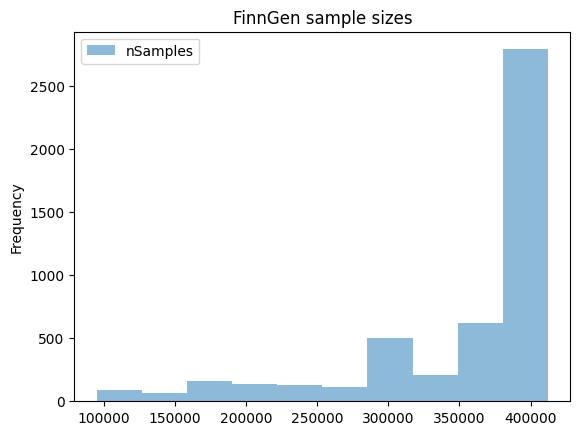

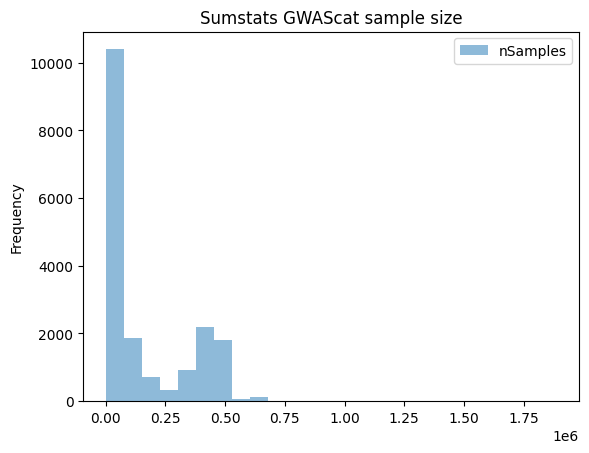

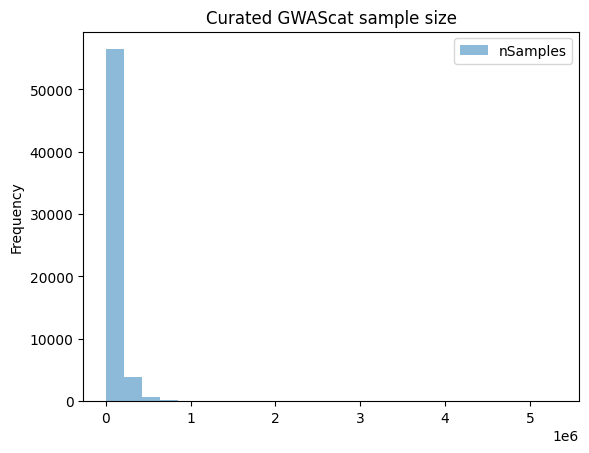

In [7]:
# study_index='gs://genetics_etl_python_playground/releases/24.03/study_index'
# Study Index. It has different files for different datasource (FinnGen, GWASCat, eQTLcat).
finngen_index_path=f"{release_path}/{release_ver}/study_index/finngen"
eqtl_index_path=f"{release_path}/{release_ver}/study_index/eqtl_catalog"
gwascat_path=f"{release_path}/{release_ver}/study_index/gwas_catalog"

# FinnGen:
finngen_index=session.spark.read.parquet(finngen_index_path, recursiveFileLookup=True)
# Number of studies.
print("Number of unique finngen studies: ", finngen_index.select(f.col("studyId")).distinct().count())
# The histogram/density plot for total sample size
finngen_index.select(f.col("nSamples")).toPandas().plot.hist(bins=10, alpha=0.5, label="FinnGen sample size", title="FinnGen sample sizes")
# eQTLcat:
# Number of studies
eqtl_index=session.spark.read.parquet(eqtl_index_path, recursiveFileLookup=True)
print("Number of unique eQTLcat studies: ", eqtl_index.select(f.col("studyId")).distinct().count())
# Number of tissues, list of tissues
print("Number of unqiue eQTLcat tissues: ", eqtl_index.select(f.col("tissueFromSourceId")).distinct().count())
#eqtl_index.select(f.col("tissueFromSourceId")).distinct().show(truncate=False)

# Gwas Catalog:
gwascat_index=session.spark.read.parquet(gwascat_path, recursiveFileLookup=True)
# Number of GWAS curated studies
print("Number of unique gwascat studies: ", gwascat_index.select(f.col("studyId")).distinct().count())
# Number of studies with full GWAS sumstats
print("Number of unique SUMSTATS gwascat studies: ", gwascat_index.filter(f.col("hasSumstats") == True).select(f.col("studyId")).distinct().count())
#gwascat_index
# The histogram/density plot for total sample size separately for curated studies and full GWAS
gwascat_index.filter(f.col("hasSumstats") == True).select(f.col("nSamples")).toPandas().plot.hist(bins=25, alpha=0.5, label="Sumstats GWAScat sample size", title="Sumstats GWAScat sample size")
gwascat_index.filter(f.col("hasSumstats") == False).select(f.col("nSamples")).toPandas().plot.hist(bins=25, alpha=0.5, label="Sumstats GWAScat sample size", title="Curated GWAScat sample size")
     

Number of unique finngen susie CSs:  13966
Number of finngen studies with at least one CS:  1194
Number of CS with top SNP PP > 0.9:  1898


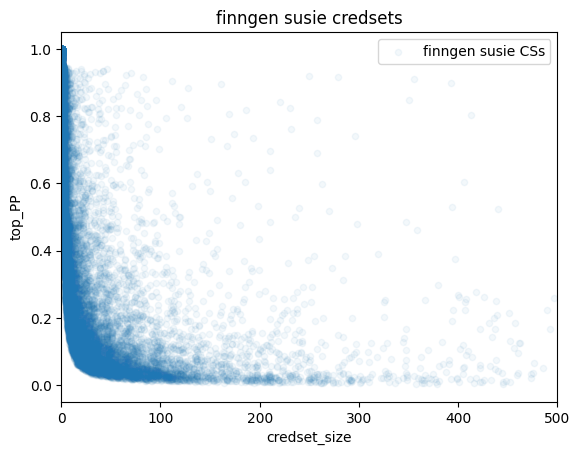

In [28]:
# Credible_set. Please use Daniels’ notebook as a reference. For each subfolder:
# finngen susie:
finngen_susie_path=f"{release_path}/{release_ver}/credible_set/finngen_susie"
# Number of CSs.
finngen_susie=session.spark.read.parquet(finngen_susie_path, recursiveFileLookup=True)
print("Number of unique finngen susie CSs: ", finngen_susie.select("studyId", "region", "credibleSetIndex").distinct().count())
# Number of unique studyids with at leas one CS.
print("Number of finngen studies with at least one CS: ", finngen_susie.select("studyId").distinct().count())
# The descriptive summary of 99% CS size and histogram/density plot
finngen_susie.select("studyId", "region", "credibleSetIndex", "locus.posteriorProbability").withColumn("top_PP", f.col("posteriorProbability").getItem(0)).withColumn("credset_size", f.size(f.col("posteriorProbability"))).toPandas().plot.scatter(x="credset_size", y="top_PP", xlim=[0, 500], alpha=0.05, label="finngen susie CSs", title="finngen susie credsets")
# Number of CSs with at leas one SNP with PIP>0.9
print("Number of CS with top SNP PP > 0.9: ", finngen_susie.select("studyId", "region", "credibleSetIndex", "locus.posteriorProbability").withColumn("top_PP", f.col("posteriorProbability").getItem(0)).filter(f.col("top_PP") > 0.9).count())
# Optional: the scatter plot of number of CSs per stydyid vs study sample size


Number of unique eqtl catalog susie CSs:  2055350


Number of eqtl catalog studies with at least one CS:  1801315


Number of CS with top SNP PP > 0.9:  386227


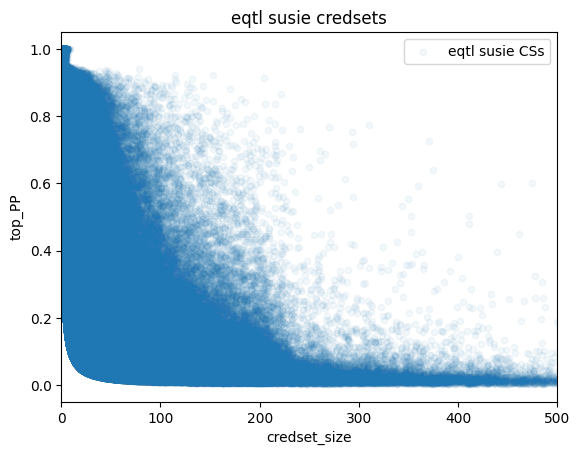

In [30]:
# Credible_set. Please use Daniels’ notebook as a reference. For each subfolder:
# eqtl catalog susie:
eqtlcat_susie_path=f"{release_path}/{release_ver}/credible_set/eqtl_catalog_susie"
# Number of CSs.
eqtlcat_susie=session.spark.read.parquet(eqtlcat_susie_path, recursiveFileLookup=True)
print("Number of unique eqtl catalog susie CSs: ", eqtlcat_susie.select("studyId", "region", "credibleSetIndex").distinct().count(), " in ", eqtlcat_susie.select("studyId").distinct().count(), " studies.")
# Number of unique studyids with at leas one CS.
print("Number of eqtl catalog studies with at least one CS: ", eqtlcat_susie.select("studyId").distinct().count())
# The descriptive summary of 99% CS size and histogram/density plot
eqtlcat_susie_fm=eqtlcat_susie.select("studyId", "region", "credibleSetIndex", "locus.posteriorProbability").withColumn("top_PP", f.col("posteriorProbability").getItem(0)).withColumn("credset_size", f.size(f.col("posteriorProbability")))
eqtlcat_susie_fm.select("credset_size", "top_PP").toPandas().plot.scatter(x="credset_size", y="top_PP", xlim=[0, 500], alpha=0.05, label="eqtl susie CSs", title="eqtl susie credsets")
# Number of CSs with at leas one SNP with PIP>0.9
print("Number of CS with top SNP PP > 0.9: ", eqtlcat_susie_fm.filter(f.col("top_PP") > 0.9).count())
# Optional: the scatter plot of number of CSs per stydyid vs study sample size

Number of unique gwas catalog sumstats CSs:  247782  in  9679  studies.


Number of CS with top SNP PP > 0.9:  77724


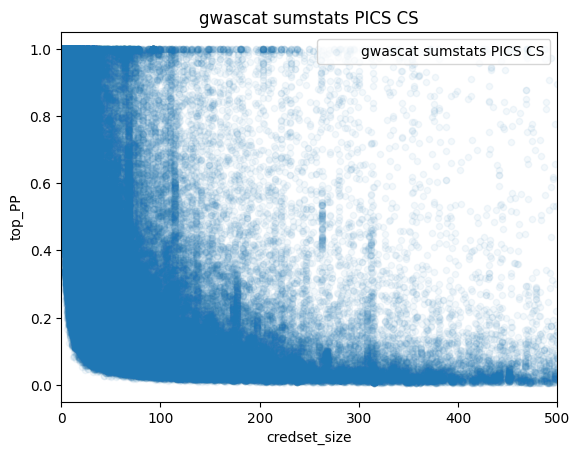

In [39]:
# Credible_set. Please use Daniels’ notebook as a reference. For each subfolder:
# gwas catalog sumstats (PICs):
gwascat_sumstats_path=f"{release_path}/{release_ver}/credible_set/gwas_catalog_summary_statistics"
# Number of CSs.
gwascat_sumstats=session.spark.read.parquet(gwascat_sumstats_path, recursiveFileLookup=True)
#gwascat_sumstats.printSchema()
print("Number of unique gwas catalog sumstats CSs: ", gwascat_sumstats.select("studyLocusId").distinct().count(), " in ", gwascat_sumstats.select("studyId").distinct().count(), " studies.")
gwascat_sumstats_fm=gwascat_sumstats.select("studyId", "studyLocusId", "locus.posteriorProbability").withColumn("top_PP", f.col("posteriorProbability").getItem(0)).withColumn("credset_size", f.size(f.col("posteriorProbability")))
gwascat_sumstats_fm.select("credset_size", "top_PP").toPandas().plot.scatter(x="credset_size", y="top_PP", xlim=[0, 500], alpha=0.05, label="gwascat sumstats PICS CS", title="gwascat sumstats PICS CS")
print("Number of CS with top SNP PP > 0.9: ", gwascat_sumstats_fm.filter(f.col("top_PP") > 0.9).count())

Number of unique gwas catalog curated CSs:  531198  in  35662  studies.


Number of CS with top SNP PP > 0.9:  91998


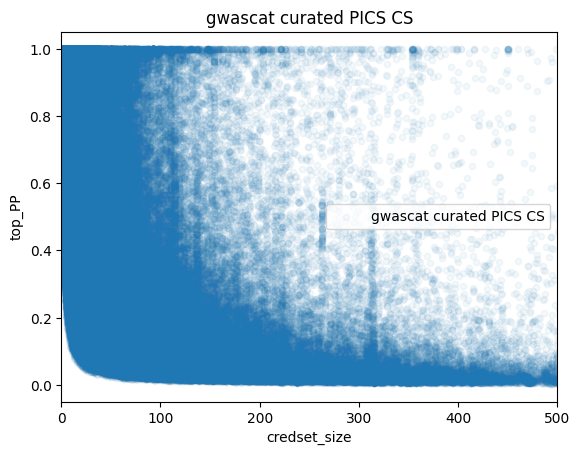

In [41]:
# gwas catalog curated (PICs):
gwascat_sumstats_path=f"{release_path}/{release_ver}/credible_set/gwas_catalog_curated"
# Number of CSs.
gwascat_sumstats=session.spark.read.parquet(gwascat_sumstats_path, recursiveFileLookup=True)
#gwascat_sumstats.printSchema()
print("Number of unique gwas catalog curated CSs: ", gwascat_sumstats.select("studyLocusId").distinct().count(), " in ", gwascat_sumstats.select("studyId").distinct().count(), " studies.")
gwascat_sumstats_fm=gwascat_sumstats.select("studyId", "studyLocusId", "locus.posteriorProbability").withColumn("top_PP", f.col("posteriorProbability").getItem(0)).withColumn("credset_size", f.size(f.col("posteriorProbability")))
gwascat_sumstats_fm.select("credset_size", "top_PP").toPandas().plot.scatter(x="credset_size", y="top_PP", xlim=[0, 500], alpha=0.05, label="gwascat curated PICS CS", title="gwascat curated PICS CS")
print("Number of CS with top SNP PP > 0.9: ", gwascat_sumstats_fm.filter(f.col("top_PP") > 0.9).count())

In [13]:
# Colocalisation. Not sure. But probably something like this:
# Number of coloclisation analyses of GWAS vs eQTLs
# Number of signals of colocalisation
# The average number of coloclisation signals per CS for each data/FM separately (GWAS curated pics, Finngen pics, Finngen susise, GWAS cat pics) -->

<!-- locus_to_gene_gold_standard.json
Number of variant-EFO pairs
Locus to gene model
Don’t know. Skip?
L2G prediction. Please use Daniels’ notebook as reference. For each datasource sepratly:
Histogram/density plot of l2g distribution.
Number of CS with at least one gene with L2G>=0.5
Number of CS with more than one gene with L2G>=0.5 -->

In [44]:
coloc_path=f"{release_path}/{release_ver}/colocalisation"
coloc=session.spark.read.parquet(coloc_path, recursiveFileLookup=True)

print("Number of colocalisations: ", coloc.count())

Number of colocalisations:  46728996


There are 9588999  locus to gene predictions for 599535  unique studyloci


Where  357457  studyloci contains at least one gene with score > 0.5


Of these,  137222  studyloci contains more than one gene with score > 0.5


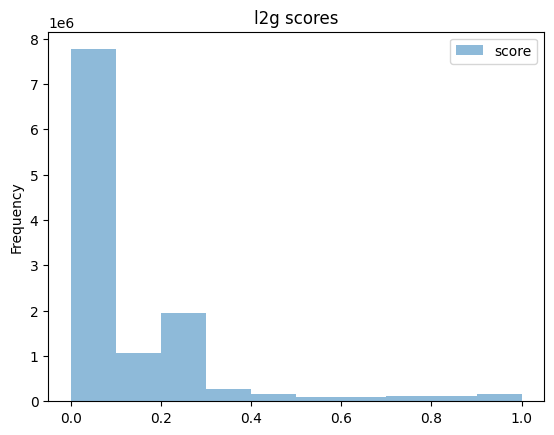

In [50]:
l2g_path=f"{release_path}/{release_ver}/locus_to_gene_predictions"
l2g=session.spark.read.parquet(l2g_path, recursiveFileLookup=True)
l2g.select("score").toPandas().plot.hist(bins=10, alpha=0.5, title="l2g scores")
print("There are", l2g.select("studyLocusId", "geneId").distinct().count(), " locus to gene predictions for", l2g.select("studyLocusId").distinct().count(), " unique studyloci")
print("Where ", l2g.filter(f.col("score") > 0.5).select("studyLocusId").distinct().count(), " studyloci contains at least one gene with score > 0.5")
print("Of these, ", l2g.filter(f.col("score") > 0.5).groupBy("studyLocusId").count().filter(f.col("count") > 1).count(), " studyloci contains more than one gene with score > 0.5")
